In [ ]:
# default_exp LW_walker

In [2]:
#export
import numpy as np
from tqdm.notebook import tqdm
from tqdm import tqdm as tqdmC
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

from rl_optimal_search.environment import isBetween_ab_Vec


# Lévy Walks

In [3]:
#export
def lw_step(alpha, steps = 1):
    return (1 - np.random.rand(steps))**(-1/alpha)

def lw_trajs(N = 1, T = 100, alpha = 1, L = None, BC = 'reflectant'):
    
    pos = np.zeros((N, T, 2))
    
    if L is None:
        
        angles = np.random.uniform(low = 0, high = 2*np.pi, size = (N, T))
        steps = (1 - np.random.rand(N, T))**(-1/alpha)
        pos[:, :, 0], pos[:, :, 1] = [steps*np.cos(angles), steps*np.sin(angles)] 
   
        return np.cumsum(pos, axis = 1)

    else:
        
        pos = np.zeros((N, T, 2))
        pos[:, 0, :] = np.random.rand(N, 2)*L

        for t in tqdm(range(1, T)):

            angles = np.random.uniform(low = 0, high = 2*np.pi, size = N)
            steps = (1 - np.random.rand(N))**(-1/alpha)
            pos[:, t, 0] = pos[:, t-1, 0] + steps*np.cos(angles)
            pos[:, t, 1] = pos[:, t-1, 1] + steps*np.sin(angles)


        if BC == 'reflectant':
            while np.max(pos[:, t, :])>L or np.min(pos[: ,t, :])< 0: 
                pos[pos > L] = pos[pos > L] - 2*(pos[pos > L] - L)
                pos[pos < 0] = - pos[pos < 0]


        elif BC == 'periodic':
            while np.max(pos[:, t, :])>L or np.min(pos[: ,t, :])< 0: 
                pos[pos > L] = pos[pos > L] - L
                pos[pos < 0] = L + pos[pos < 0]     
        
            
        
        return pos




In [59]:
alpha = 0.5; L = 10000
N = int(1e6); T = int(1e3)

trajs = lw_trajs(N = N, T = T, alpha = alpha, L = L, BC = None)

if L is not None:
#     trajsm  = (trajs.reshape(T, N, 2) - trajs[:, 0, :]).reshape(N, T, 2)
    trajsm  = (trajs[:,:,0].transpose() - trajs[:,0,0]).transpose()


msd = np.mean(trajsm**2, axis= 0)
# msd = np.mean(msd, axis = 1)

  0%|          | 0/999 [00:00<?, ?it/s]

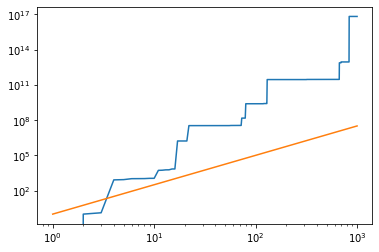

In [60]:
t = np.arange(1, msd.shape[0]+1)
plt.loglog(t, msd/msd[1], label = 'Numerics')
plt.loglog(t, t**(3-alpha))

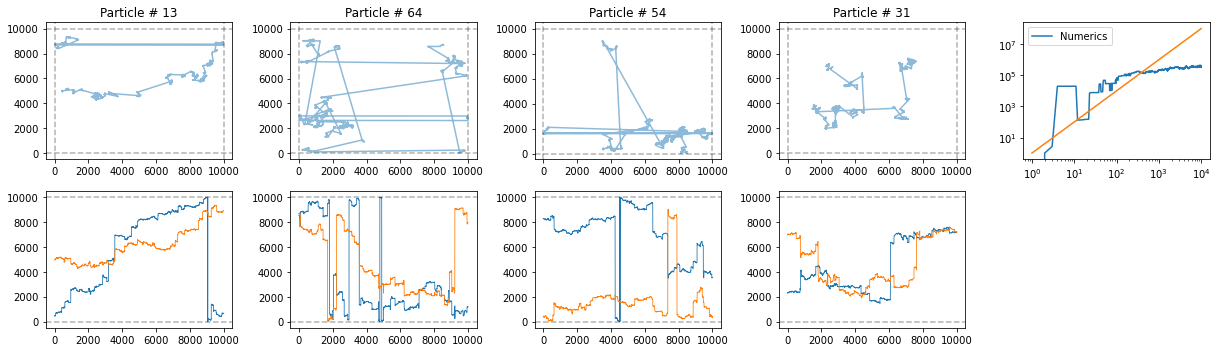

In [289]:
fig, axs = plt.subplots(2, 5, figsize = (17, 5), tight_layout = True)

for ax in axs[:, :-1].transpose():
    part = np.random.randint(N)    
    ax[0].set_title(f'Particle # {part}')
    ax[0].plot(trajs[part, :, 0], trajs[part, :, 1], alpha = 0.5)
    

    ax[1].plot(trajs[part, :, 0], '-', label = 'X', ms = 3, lw = 0.8)
    ax[1].plot(trajs[part, :, 1], '-', label = 'Y', ms = 3, lw = 0.8)

    
    if L is not None:
        ax[0].axhline(L, ls = '--', alpha = 0.3, c = 'k')
        ax[0].axhline(0, ls = '--', alpha = 0.3, c = 'k')
        ax[0].axvline(L, ls = '--', alpha = 0.3, c = 'k')
        ax[0].axvline(0, ls = '--', alpha = 0.3, c = 'k')
        
        ax[1].axhline(L, ls = '--', alpha = 0.3, c = 'k')
        ax[1].axhline(0, ls = '--', alpha = 0.3, c = 'k')

    
t = np.arange(1, msd.shape[0]+1)
axs[0, -1].loglog(t, msd/msd[1], label = 'Numerics')
axs[0, -1].loglog(t, t**(3-alpha))
axs[0, -1].legend()

axs[1, -1].set_axis_off()


# Introducing Targets

In [5]:
#export
def LW_search(Nt = 100, at = 1, ls = 1,
              rho = 1e-3,
              L= 1000,   
              N = 1000, T = 1000,
              alpha = 0.5,
              BC = 'periodic'):

    diag = np.sqrt(2*L**2)

    target_positions = np.random.rand(Nt, 2)*L

    pos = np.zeros((N, T, 2))
    pos[:, 0, :] = np.random.rand(N, 2)*L

    encounter = np.zeros((N, T)).astype(bool)
    
    real_steps = []


    counter_target = 0
    for t in tqdmC(range(1, T)):

        angles = np.random.uniform(low = 0, high = 2*np.pi, size = N)
        steps = (1 - np.random.rand(N))**(-1/alpha)

        steps[steps > diag] = diag
        pos[:, t, 0] = pos[:, t-1, 0] + steps*np.cos(angles)
        pos[:, t, 1] = pos[:, t-1, 1] + steps*np.sin(angles)
        
        if BC == 'reflectant':
            while np.max(pos[:, t, :])>L or np.min(pos[: ,t, :])< 0: 
                pos[pos > L] = pos[pos > L] - 2*(pos[pos > L] - L)
                pos[pos < 0] = - pos[pos < 0]
        if BC == 'periodic':      
            while np.max(pos[:, t, :])>L or np.min(pos[: ,t, :])< 0: 
                pos[pos > L] = pos[pos > L] - L
                pos[pos < 0] = L + pos[pos < 0] 


        masked = np.array([False]*N)
        for idxT, pT in enumerate(target_positions):
            
            # flight, not walk! 
            mask = isBetween_ab_Vec(pos[:, t, :], pos[:, t-1, :], pT, epsilon = at)

            masked += np.array(mask)
            
            # Check real distance travelled
            if np.sum(mask) > 0:
                real_steps += np.abs(pos[mask == True, t, :].copy() - pT).tolist()[0]
            
        
            pos[mask == True, t, :] = pT
        
        encounter[:, t] = masked
        sum_m = np.sum(masked)

        '''See that we want to walk, not to fly, because it's closer to what RL will do'''
        if sum_m > 0:
            angle = np.random.uniform(low = 0, high = 2*np.pi, size = sum_m)
            pos[masked == True, t, 0] += ls*np.cos(angle)
            pos[masked == True, t, 1] += ls*np.sin(angle)

        
                
    return encounter, real_steps
                

# Comparing given step distribution and size of steps when encountering

In [ ]:
Nt = 4000
density = 0.02
N = 2000; T = int(100)
L = 100
at = 0.5
lss = np.linspace(1, 3, 10)

alphas = np.linspace(0.1, 1.9, 20)

m_eta = np.zeros((len(lss), len(alphas)))
std_eta = np.zeros_like(m_eta)

for idx_ls, ls in enumerate(lss):

    results = np.array(Parallel(n_jobs=len(alphas))(delayed(LW_search)(Nt = Nt, N = N, T = T, alpha = alpha, L = L, at = at, ls = ls)
                    for alpha in alphas), dtype = object)
    
    encs = results[:, 0]    
    
    for idx_a, e in enumerate(encs):
        m_eta[idx_ls, idx_a] = e.mean()
        std_eta[idx_ls, idx_a] = e.std()

# enc, real_steps = LW_search(Nt = Nt, N = N, T = T, alpha = alpha, L = L, at = at, ls =)

In [12]:
encs.shape

(20,)

In [8]:
encs = results[:, 0]

In [9]:
m_eta = []
std_eta = []
for e in encs:
    m_eta.append(e.mean())
    std_eta.append(e.std())

In [14]:
m_eta.shape

(10, 20)

In [10]:
std_eta/np.sqrt(e.shape[0]*e.shape[1])

array([0.00104863, 0.00104679, 0.00104451, 0.00104209, 0.00103815,
       0.00103827, 0.00103717, 0.00103416, 0.00102878, 0.00103289,
       0.00102331, 0.00102583, 0.00102577, 0.00102117, 0.00102136,
       0.00101842, 0.00101647, 0.0010121 , 0.00101407, 0.00100818])

<ErrorbarContainer object of 3 artists>

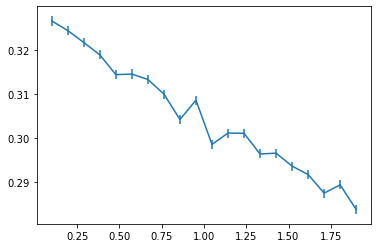

In [11]:
for m, e in zip(m_eta, std_eta):
    plt.errorbar(alphas, m, yerr=s/np.sqrt(e.shape[0]*e.shape[1]))

<ErrorbarContainer object of 3 artists>

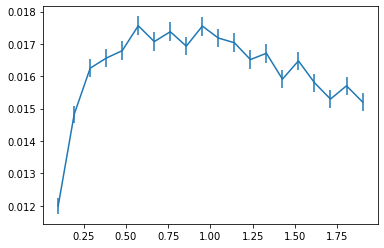

In [24]:
plt.errorbar(alphas, m_eta, yerr=std_eta/np.sqrt(e.shape[0]*e.shape[1]))

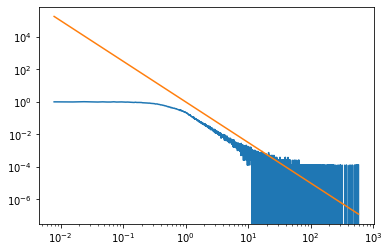

In [25]:
h, e = np.histogram(real_steps, bins = int(len(real_steps)*0.1))
plt.loglog(e[1:], h/h[0])
plt.plot(e[1:], e[1:]**(-alpha-1))

In [28]:
np.ceil(real_steps[:100])

array([1., 1., 1., 1., 1., 1., 4., 2., 3., 1., 5., 7., 1., 1., 1., 1., 2.,
       2., 2., 8., 2., 2., 2., 1., 1., 1., 1., 1., 4., 8., 1., 3., 1., 4.,
       1., 2., 1., 2., 1., 1., 1., 1., 1., 1., 1., 3., 1., 1., 1., 1., 2.,
       1., 1., 1., 4., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 2., 1., 1., 1., 1., 2., 1., 2., 1., 2., 1., 1., 1., 1., 1.,
       1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 1., 1.])

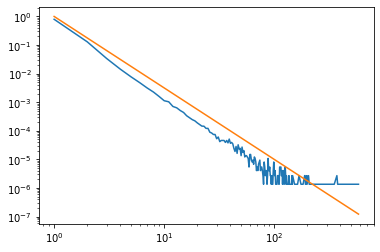

In [34]:
int_steps = np.ceil(real_steps)
h, e = np.unique(int_steps, return_counts=True)
plt.loglog(h, e/np.sum(e))
plt.plot(h, h**(-alpha-1))

In [9]:

70%30

10

In [34]:
len(enc[1])

9498

In [39]:
alpha = 1

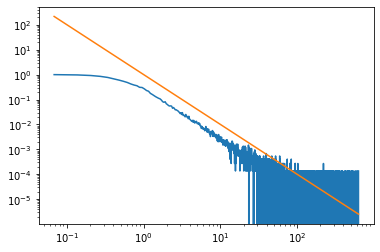

In [44]:
h, e = np.histogram(enc[1], bins = int(len(enc[1])*0.1))
plt.loglog(e[1:], h/h[0])
plt.plot(e[1:], e[1:]**(-alpha-1))

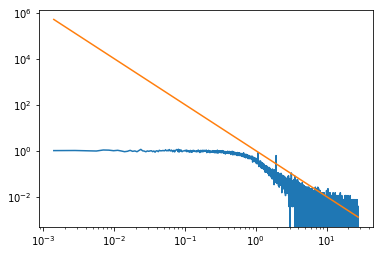

In [12]:
h, e = np.histogram(enc[1], bins = int(len(enc[1])*0.1))
plt.loglog(e[1:], h/h[0])
plt.plot(e[1:], e[1:]**(-alpha-1))

In [18]:
e

array([2.37023094e-06, 1.40173495e-03, 2.80109966e-03, ...,
       2.79802998e+01, 2.79816992e+01, 2.79830986e+01])

In [17]:
h, e = np.histogram(enc[1], bins = int(len(enc[1])*0.1))
e = e[:-1]
h[e == 1] =

143334

In [27]:
Nt = 1000
N = 10000; T = int(1e4)
L = 450 
at = 0.5

alphas = np.linspace(0.2, 2, num = 18)
pos_alpha = np.zeros((len(alphas), N, T, 2))
encounter_alpha = np.zeros((len(alphas), N, T, 2))


info = Parallel(n_jobs=18)(delayed (LW_search) (Nt = Nt, N = N, T = T, alpha = alpha, L = L, at = at)
                                    for alpha in alphas)
    

MemoryError: Unable to allocate 763. MiB for an array with shape (10000, 10000) and data type float64

### Results

In [29]:
enc = np.zeros(len(alphas))
mean = np.zeros(len(alphas))
std = np.zeros(len(alphas))



for idx, ia in enumerate(info):
    enc[idx] = np.sum(ia[1])
    totalN = np.sum(ia[1], axis = 1)
    mean[idx] = np.mean(totalN)
    std[idx] = np.std(totalN)

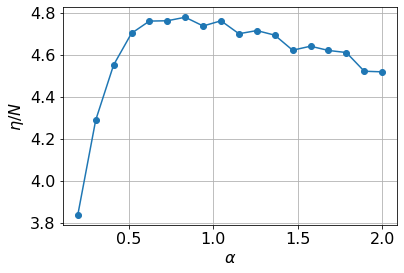

In [57]:
plt.plot(alphas, mean, 'o-')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\eta / N$')
plt.grid('on')

### Some trajectory examples

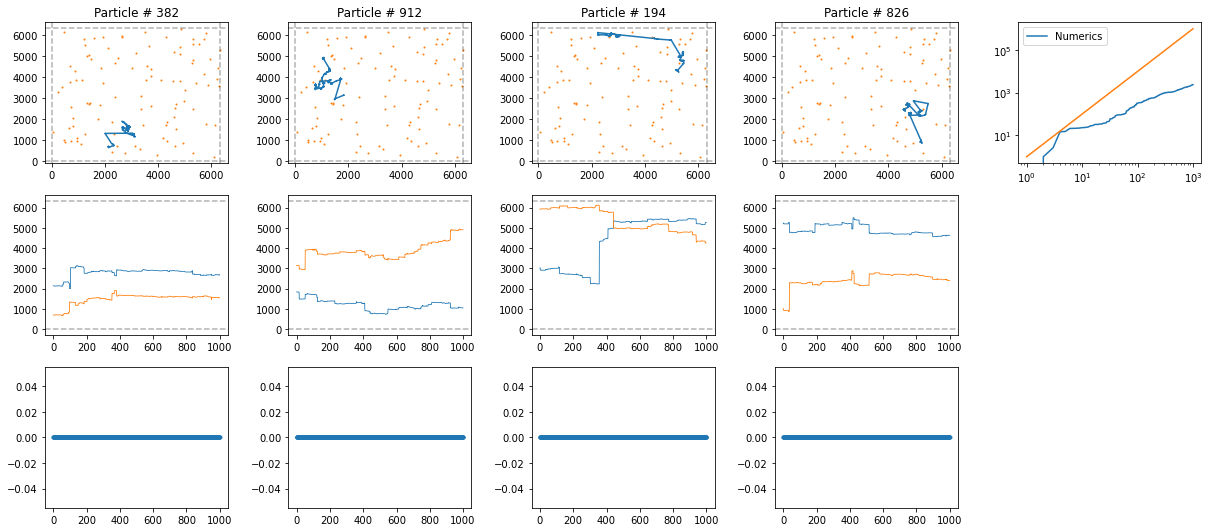

In [472]:
fig, axs = plt.subplots(3, 5, figsize = (17, 7.5), tight_layout = True)

trajs = pos
if L is not None:
    trajsm  = (trajs[:,:,0].transpose() - trajs[:,0,0]).transpose()
msd = np.mean(trajsm**2, axis= 0)



for ax in axs[:, :-1].transpose():
    part = np.random.randint(N)    
    ax[0].set_title(f'Particle # {part}')
    ax[0].plot(trajs[part, :, 0], trajs[part, :, 1], alpha = 1)
    ax[0].scatter(target_positions[:, 0], target_positions[:, 1], c = 'C1', s = 1)
    

    ax[1].plot(trajs[part, :, 0], '-', label = 'X', ms = 3, lw = 0.8)
    ax[1].plot(trajs[part, :, 1], '-', label = 'Y', ms = 3, lw = 0.8)
    
    ax[2].plot(encounter[part, :], '.')

    
    if L is not None:
        ax[0].axhline(L, ls = '--', alpha = 0.3, c = 'k')
        ax[0].axhline(0, ls = '--', alpha = 0.3, c = 'k')
        ax[0].axvline(L, ls = '--', alpha = 0.3, c = 'k')
        ax[0].axvline(0, ls = '--', alpha = 0.3, c = 'k')
        
        ax[1].axhline(L, ls = '--', alpha = 0.3, c = 'k')
        ax[1].axhline(0, ls = '--', alpha = 0.3, c = 'k')

    
t = np.arange(1, msd.shape[0]+1)
axs[0, -1].loglog(t, msd/msd[1], label = 'Numerics')
axs[0, -1].loglog(t, t**(3-alpha))
axs[0, -1].legend()

axs[1, -1].set_axis_off()
axs[2, -1].set_axis_off()



# NBDEV Export

In [2]:
from nbdev.export import notebook2script
notebook2script()

Converted discrete_RL_walker.ipynb.
Converted PS_single_RL.ipynb.
Converted single_LW_walker.ipynb.
Converted single_RL_walker.ipynb.
